### **Topic 0: Discovering Top-k periodic high-utility itemsets from uncertain databases**


### **1. Classes / Models**


In [338]:
import random
import datetime
import heapq
from dataclasses import dataclass
from collections import namedtuple
import os
import time
import matplotlib.pyplot as plt

In [339]:
class Item:
    def __init__(self, item: str, utility: int):
        self.item = item
        self.utility = utility
        self._twu = 0

    @property
    def twu(self) -> int:
        return self._twu

    @twu.setter
    def twu(self, value: int) -> None:
        self._twu = value

    def __repr__(self):
        return f"{self.item}"

    def __eq__(self, other):
        if isinstance(other, Item):
            return self.item == other.item and self.utility == other.utility
        return False

    def __hash__(self):
        return hash((self.item, self.utility))


def check_order_condition(a: Item, b: Item) -> bool:
    """_summary_

    Args:
        a (Item): an item
        b (Item): an item

    Returns:
        bool: return b < a
    """
    if a.utility * b.utility < 0:
        return a.utility < b.utility
    elif a.utility * b.utility > 0:
        if a.twu == b.twu:
            if a.utility == b.utility:
                return a.item > b.item
            return b.utility > a.utility
        return a.twu > b.twu
    return False


def check_order_item_and_set(item: Item, item_set: set[Item]) -> bool:
    """_summary_
    This function is used to check an item > item-set or not.
    Example: a > {b, c}
    Args:
        item (Item): an item
        item_set (set[Item]): an item set

    Returns:
        bool: return item > item_set
    """
    for i in item_set:
        if check_order_condition(item, i) == False:
            return False
    return True


class TransItem:
    def __init__(self, item: Item, quantity: int, probability: float):
        self.item = item
        self.quantity = quantity
        self.probability = probability

    def __repr__(self):
        return f"{self.item},{self.quantity},{self.probability}"

    def get_total_probability(self):
        return self.quantity * self.probability

In [340]:
Periodic = namedtuple("Periodic", ["min_per", "max_per", "avg_per"])

@dataclass
class Utilities:
    tid: int
    pro: float
    pu: int
    nu: int
    ru: int

In [341]:
class Transaction:
    def __init__(self, id: int, trans_items: list[TransItem]):
        self.id = id
        self.trans_items_list = [trans_item.item for trans_item in trans_items]
        self.trans_items_dict = {
            trans_item.item: (trans_item.quantity, trans_item.probability)
            for trans_item in trans_items
        }

    def __repr__(self):
        return f"Transaction(id={self.id}, items={list(self.trans_items_dict.keys())}, quantities={list(self.trans_items_dict.values())})"

    def contains_item_set(self, item_set: set[Item]) -> bool:
        # Check directly against the dictionary keys
        return item_set.issubset(self.trans_items_dict.keys())

    def get_quantity_of_item(self, item: Item) -> int:
        # Access quantity directly from the dictionary
        return self.trans_items_dict.get(item, (0, 0))[0]

    def get_probability_of_item(self, item: Item) -> float:
        # Access probability directly from the dictionary
        return self.trans_items_dict.get(item, (0, 0))[1]

    def get_positive_utility_of_trans(self):
        put = 0
        positive_item = {item for item in self.get_items() if item.utility > 0}
        for item in positive_item:
            put += item.utility * self.get_quantity_of_item(item)
        return put

    def get_items(self) -> set[Item]:
        return set(self.trans_items_dict.keys())

    def get_probability_of_item_set(self, item_set: set[Item]) -> float:
        if not self.contains_item_set(item_set):
            return 0.0
        total_probability = 1.0
        for item in item_set:
            total_probability *= self.get_probability_of_item(item)
        return total_probability

    def _calculate_utility(self, item_set: set[Item], condition: callable) -> int:
        total_utility = 0
        for item in item_set:
            quantity = self.get_quantity_of_item(item)
            if condition(item.utility):
                total_utility += item.utility * quantity
        return total_utility

    def get_positive_utility_of_item_set(self, item_set: set[Item]) -> int:
        return self._calculate_utility(item_set, lambda utility: utility > 0)

    def get_negative_utility_of_item_set(self, item_set: set[Item]) -> int:
        return self._calculate_utility(item_set, lambda utility: utility < 0)

    def get_utility_of_item_set(self, item_set: set[Item]) -> int:
        return self._calculate_utility(item_set, lambda utility: True)

    def sort_trans_items_by_twu_and_utility(self) -> None:
        def sort_key(item: Item) -> tuple:
            return (0 if item.utility > 0 else 1, item.twu, -item.utility, item.item)

        self.trans_items_list.sort(key=sort_key)

    def get_remaining_utility_of_item_set(self, item_set: list[Item]) -> int:
        ru = 0
        if item_set:
            last_item = item_set[-1]
            index = self.trans_items_list.index(last_item)
            for i in range(index + 1, len(self.trans_items_list)):
                item = self.trans_items_list[i]
                if item.utility > 0 and item not in item_set:
                    quantity = self.trans_items_dict[item][0]
                    ru += item.utility * quantity
        return ru

In [342]:
class AbstractList:
    def __init__(self, item_set: set["Item"], utility_values: list["Utilities"]):
        self.item_set = item_set
        self.utility_values = utility_values

    def get_ru(self) -> int:
        return sum(i.ru for i in self.utility_values)

    def get_pu(self) -> int:
        return sum(i.pu for i in self.utility_values)

    def get_nu(self) -> int:
        return sum(i.nu for i in self.utility_values)

    def get_pro(self) -> float:
        return sum(i.pro for i in self.utility_values)

    def get_utility(self) -> int:
        return sum(i.pu + i.nu for i in self.utility_values)

    def __repr__(self):
        items_str = ", ".join(str(item) for item in self.item_set)
        utility_values_str = ", \n".join(
            str(utility) for utility in self.utility_values
        )
        return f"{self.__class__.__name__}(\n  Items: [{items_str}]\n  Utility Values: \n[{utility_values_str}]\n)"

    def __eq__(self, other):
        if not isinstance(other, AbstractList):
            return False
        return (
            self.item_set == other.item_set
            and self.utility_values == other.utility_values
        )

    def __hash__(self):
        return hash(frozenset(self.item_set)) ^ hash(tuple(self.utility_values))


class PNUList(AbstractList):
    def __init__(self, item_set: set["Item"], utility_values: list["Utilities"]):
        super().__init__(item_set, utility_values)


class MList(AbstractList):
    def __init__(
        self,
        item_set: set["Item"],
        subset: PNUList,
        subset_prefix: PNUList,
        utility_values: list["Utilities"],
        pu: int,
        ru: int,
    ):
        super().__init__(item_set, utility_values)
        self.subset = subset
        self.subset_prefix = subset_prefix
        self.pu = pu
        self.ru = ru

    def __repr__(self):
        return (
            f"MList("
            f"item_set={list(self.item_set)}, "
            f"subset={self.subset}, "
            f"subset_prefix={self.subset_prefix})"
        )

In [343]:
class PriorityQueue:
    def __init__(self, max_size: int):
        self.max_size = max_size
        self.heap: list[tuple[int, set[Item], Periodic]] = []
        self.item_sets: set[frozenset] = set()

    def push(self, utility: int, item_set: set, periodic: Periodic):
        fs_item_set = frozenset(item_set)
        if fs_item_set in self.item_sets:
            return

        if len(self.heap) < self.max_size:
            heapq.heappush(self.heap, (utility, item_set, periodic))
            self.item_sets.add(fs_item_set)
        else:
            if utility > self.heap[0][0]:
                removed = heapq.heappushpop(self.heap, (utility, item_set, periodic))
                self.item_sets.remove(frozenset(removed[1]))
                self.item_sets.add(fs_item_set)

    def get_min_utility(self) -> int:
        if self.heap:
            return self.heap[0][0]
        return float("-inf")

    def sort(self) -> list[tuple[int, set[Item], Periodic]]:
        return sorted(self.heap, reverse=True)

    def print_items(self):
        for utility, item_set, periodic in self.sort():
            formatted_periodic = f"(min_per={periodic.min_per}, max_per={periodic.max_per}, avg_per={periodic.avg_per:.2f})"
            print(f"{item_set} : {utility} : {formatted_periodic}")

### **2. Preliminaries and Formulation**


##### **2.0. Transaction Dictionary**


In [344]:
def create_transaction_dictionary(item_list: list[Item], database: list[Transaction]):
    trans_dict: dict[Item, set[Transaction]] = {item: set() for item in item_list}
    for trans in database:
        trans_items = trans.get_items()
        for item in trans_items:
            trans_dict.get(item).add(trans)
    return trans_dict

##### **2.1. Periodic Pattern**


In [345]:
def create_item_transId_dict(
    item_list: list[Item], db: list[Transaction]
) -> dict[Item, list[int]]:
    transaction_index = {item: list() for item in item_list}
    for trans in db:
        for item in trans.trans_items_dict.keys():
            transaction_index[item].append(trans.id)
    return transaction_index

In [346]:
def find_all_trans_ids_contained_item_set(
    item_set: set[Item], create_item_transId_dict: dict[Item, list[int]]
) -> list[int]:
    trans_ids = list()
    for item in item_set:
        if not trans_ids:
            trans_ids = set(create_item_transId_dict[item])
            continue
        trans_ids &= set(create_item_transId_dict[item])
    return sorted(trans_ids) if trans_ids else []

In [347]:
def find_min_max_avg_periodic_of_item_set(
    item_set: set[Item], db: list[Transaction], transaction_index: dict[Item, list[int]]
) -> Periodic:
    trans_ids = find_all_trans_ids_contained_item_set(item_set, transaction_index)
    if not trans_ids:
        return Periodic(0, 0, 0)

    m = len(trans_ids)
    max_per, min_per, total_per = 0, float("inf"), 0
    prev = 0
    for _, trans_id in enumerate(trans_ids):
        per = trans_id - prev
        max_per = max(max_per, per)
        min_per = min(min_per, per)
        total_per += per
        prev = trans_id
    final_per = len(db) - prev
    max_per = max(max_per, final_per)
    min_per = min(min_per, final_per)
    total_per += final_per
    avg_per = total_per / (m + 1)
    return Periodic(min_per, max_per, avg_per)

##### **2.1 Transaction Weight Utility**


In [348]:
def calculate_transaction_weight_utility(
    item_set: set[Item], database: list[Transaction]
):
    twu = 0
    for trans in database:
        if trans.contains_item_set(item_set):
            twu += trans.get_positive_utility_of_trans()
    return twu

##### **2.3. Utility of an Itemset**


In [349]:
def calculate_utility_of_item_set_in_database(
    item_set: set[Item], trans_dict: dict[Item, set[Transaction]]
) -> int:
    transaction_set: set[Transaction] = set()
    for item in item_set:
        if not transaction_set:
            transaction_set = set(trans_dict[item])
            continue
        transaction_set &= set(trans_dict[item])
    utility = 0
    for trans in transaction_set:
        utility += trans.get_utility_of_item_set(item_set)
    return utility

##### **2.5 Order of items**

In [350]:
def check_order_condition(a: Item, b: Item) -> bool:
    """_summary_

    Args:
        a (Item): an item
        b (Item): an item

    Returns:
        bool: return b < a
    """
    if a.utility * b.utility < 0:
        return a.utility < b.utility
    elif a.utility * b.utility > 0:
        if a.twu == b.twu:
            if a.utility == b.utility:
                return a.item > b.item
            return b.utility > a.utility
        return a.twu > b.twu
    return False

In [351]:
def check_order_item_and_set(item: Item, item_set: set[Item]) -> bool:
    """_summary_
    This function is used to check an item > item-set or not.
    Example: a > {b, c}
    Args:
        item (Item): an item
        item_set (set[Item]): an item set

    Returns:
        bool: return item > item_set
    """
    for i in item_set:
        if check_order_condition(item, i) == False:
            return False
    return True

In [352]:
def sort_items_by_twu_and_utility(items: list[Item]) -> list[Item]:
    """_summary_

    Args:
        items (list[Item]): a list item

    Returns:
        list[Item]: a sorted list by two principle:
        1. positive always takes priority over negative
        2. ascending twu value
    """

    def sort_key(item: Item) -> tuple:
        return (0 if item.utility > 0 else 1, item.twu, -item.utility, item.item)

    return sorted(items, key=sort_key)

##### **2.4. Potential / Expected Pattern**


In [353]:
def calculate_probability_of_item_set_in_database(
    item_set: set[Item], trans_dict: dict[Item, set[Transaction]]
) -> int:
    transaction_set: set[Transaction] = set()
    for item in item_set:
        if not transaction_set:
            transaction_set = set(trans_dict[item])
            continue
        transaction_set &= set(trans_dict[item])
    if not transaction_set:
        return 0.0
    probability = 1.0
    for trans in transaction_set:
        probability *= trans.get_probability_of_item_set(item_set)
    return probability

In [354]:
def calculate_probability_and_utility_of_item_set_in_database(
    item_set: set[Item], trans_dict: dict[Item, set[Transaction]]
):
    intersection_trans = set()
    for item in item_set:
        if not intersection_trans:
            intersection_trans = set(trans_dict.get(item, set()))
            continue
        intersection_trans &= trans_dict.get(item)
    p: float = 0.0
    u: int = 0
    ru: int = 0
    sorted_itemset = sort_items_by_twu_and_utility(item_set)
    for trans in intersection_trans:
        p += trans.get_probability_of_item_set(item_set)
        u += trans.get_utility_of_item_set(item_set)
        ru += trans.get_remaining_utility_of_item_set(sorted_itemset)
    return p, u, ru

##### **2.4. Probability - TWU - Utility Bin Array**


In [355]:
def create_prob_twu_utility_bin_array(
    item_list: set[Item], database: list[Transaction]
) -> tuple[list[int], list[int], list[int], dict[Item, int]]:
    n = len(item_list)
    twu_array = [0 for _ in range(n)]
    prob_array = [0 for _ in range(n)]
    utility_array = [0 for _ in range(n)]
    item_dict = {item: idx for idx, item in enumerate(item_list)}
    for trans in database:
        ptu = trans.get_positive_utility_of_trans()
        for item in trans.get_items():
            index = item_dict.get(item, -1)
            if index != -1:
                twu_array[index] += ptu
                prob_array[index] += trans.get_probability_of_item(item)
                utility_array[index] += trans.get_quantity_of_item(item) * item.utility
    return prob_array, twu_array, utility_array, item_dict

##### **2.5 Remaining Utility**


In [356]:
def calculate_remaining_utility_of_item_set_in_database(
    item_set: set[Item], trans_dict: dict[Item, set[Transaction]]
) -> int:
    transaction_set: set[Transaction] = set()
    for item in item_set:
        if not transaction_set:
            transaction_set = set(trans_dict[item])
            continue
        transaction_set &= set(trans_dict[item])
    utility = 0
    for trans in transaction_set:
        utility += trans.get_remaining_utility_of_item_set(item_set)
    return utility

##### **2.5 Local Utility**


In [357]:
def calculate_local_utility(
    alpha: set[Item], item: Item, database: list[Transaction]
) -> int:
    """_summary_

    Args:
        alpha (set[Item]): an item set
        item (Item): a combined item
        database (list[Transaction]): database

    Returns:
        int: return a local utility value of item set
    """
    lu = 0
    sorted_alpha = sort_items_by_twu_and_utility(alpha)
    for trans in database:
        if trans.contains_item_set(alpha | {item}):
            lu += trans.get_utility_of_item_set(
                alpha
            ) + trans.get_remaining_utility_of_item_set(sorted_alpha)
    return lu

##### **2.5 Subtree Utility**


In [358]:
def calculate_subtree_utility(
    alpha: set[Item],
    item: Item,
    beta_db: set[Transaction],
    trans_dict: dict[Item, set[Transaction]],
) -> int:
    item_trans: set[Transaction] = set(trans_dict.get(item))
    general_trans: set[Transaction] = item_trans & beta_db
    su = 0
    sorted_alpha = sort_items_by_twu_and_utility(alpha)
    if not alpha or check_order_condition(item, sorted_alpha[-1]):
        for trans in general_trans:
            su += (
                trans.get_utility_of_item_set(alpha)
                + trans.get_utility_of_item_set({item})
                + trans.get_remaining_utility_of_item_set([item])
            )
    return su

##### **2.5 Local & Subtree Utility Bin Array**


In [359]:
def create_local_subtree_bin_array(
    alpha: set[Item], item_list: set[Item], database: list[Transaction]
) -> tuple[list[int], list[int], list[float]]:
    n = len(item_list)
    lu_array = [0 for _ in range(n)]
    su_array = [0 for _ in range(n)]
    item_dict = {item: idx for idx, item in enumerate(item_list)}
    sorted_alpha = sort_items_by_twu_and_utility(alpha)
    set_item = set(item_list)
    for trans in database:
        alpha_util = trans.get_utility_of_item_set(alpha)
        alpha_ru = trans.get_remaining_utility_of_item_set(sorted_alpha)
        for item in trans.get_items():
            index = item_dict.get(item, -1)
            if index != -1:
                lu_array[index] += alpha_util + alpha_ru
                if item in set_item:
                    item_utility = trans.get_quantity_of_item(item) * item.utility
                    item_ru = trans.get_remaining_utility_of_item_set([item])
                    if not alpha:
                        su_array[index] += alpha_util + item_utility + item_ru
                    else:
                        if check_order_condition(item, sorted_alpha[-1]):
                            su_array[index] += alpha_util + item_utility + item_ru
    return lu_array, su_array

In [360]:
def create_local_utility_bin_array(
    alpha: set[Item], item_list: set[Item], database: list[Transaction]
):
    n = len(item_list)
    lu_array = [0 for _ in range(n)]
    item_dict = {item: idx for idx, item in enumerate(item_list)}
    sorted_alpha = sort_items_by_twu_and_utility(alpha)
    for trans in database:
        alpha_util = trans.get_utility_of_item_set(alpha)
        alpha_ru = trans.get_remaining_utility_of_item_set(sorted_alpha)
        for item in trans.get_items():
            index = item_dict.get(item, -1)
            if index != -1:
                lu_array[index] += alpha_util + alpha_ru
    return lu_array

In [361]:
def create_subtree_utility_bin_array(
    alpha: set[Item], item_list: set[Item], database: list[Transaction]
):
    n = len(item_list)
    su_array = [0 for _ in range(n)]
    item_dict = {item: idx for idx, item in enumerate(item_list)}
    sorted_alpha = sort_items_by_twu_and_utility(alpha)
    for trans in database:
        alpha_util = trans.get_utility_of_item_set(alpha)
        for item in trans.get_items():
            index = item_dict.get(item, -1)
            if index != -1:
                if not alpha or check_order_condition(item, sorted_alpha[-1]):
                    su_array[index] += (
                        alpha_util
                        + trans.get_utility_of_item_set({item})
                        + trans.get_remaining_utility_of_item_set([item])
                    )
    return su_array

In [362]:
def get_value_from_bin(
    item: Item, bin: list[int | float], item_dict: dict[Item, int | float]
):
    index = item_dict.get(item, -1)
    return bin[index] if index != -1 else 0

##### **2.5 PNU List & MList**


In [363]:
def create_pnu_lists(trans_dict: dict[Item, set[Transaction]]):
    pnu_list = []
    for item, transactions in trans_dict.items():
        utility_values_list = []
        pnu = PNUList({item}, utility_values_list)
        for trans in transactions:
            pro = trans.get_probability_of_item_set({item})
            pu = trans.get_positive_utility_of_item_set({item})
            nu = trans.get_negative_utility_of_item_set({item})
            ru = trans.get_remaining_utility_of_item_set([item])
            utility_values = Utilities(trans.id, pro, pu, nu, ru)
            utility_values_list.append(utility_values)
        pnu_list.append(pnu)
    return pnu_list

In [364]:
def find_tuple_by_trans_id(P: PNUList, target_trans_id: int) -> Utilities:
    utilities_list: list[Utilities] = P.utility_values
    for iTuple in utilities_list:
        if iTuple.tid == target_trans_id:
            return iTuple
    return None

In [365]:
def utility_list_construct(
    P: PNUList,
    Px: PNUList,
    Py: PNUList,
    min_util: int,
    user_prob_threshold: float,
):
    if not Px or not Py or not Px.utility_values or not Py.utility_values:
        return None

    x = Px.item_set
    y = Py.item_set
    xy = x | y
    utilities_list: list[Utilities] = []
    Pxy = PNUList(xy, utilities_list)

    y_dict = {utl.tid: utl for utl in Py.utility_values}
    p_dict = (
        {utl.tid: utl for utl in P.utility_values} if P and P.utility_values else {}
    )

    probability = Px.get_pro()
    utility = Px.get_pu() + Px.get_ru()

    for xTuple in Px.utility_values:
        yTuple = y_dict.get(xTuple.tid, None)

        if yTuple:
            if P and P.utility_values:
                pTuple = p_dict.get(xTuple.tid, None)
                if pTuple:
                    pro = 1e-10 if pTuple.pro == 0 else pTuple.pro
                    xyTuple = Utilities(
                        xTuple.tid,
                        xTuple.pro * yTuple.pro / pro,
                        xTuple.pu + yTuple.pu - pTuple.pu,
                        xTuple.nu + yTuple.nu - pTuple.nu,
                        yTuple.ru,
                    )
                    utilities_list.append(xyTuple)
            else:
                xyTuple = Utilities(
                    xTuple.tid,
                    xTuple.pro * yTuple.pro,
                    xTuple.pu + yTuple.pu,
                    xTuple.nu + yTuple.nu,
                    yTuple.ru,
                )
                utilities_list.append(xyTuple)
        else:
            probability -= xTuple.pro
            utility -= xTuple.pu + xTuple.ru

            if probability < user_prob_threshold or utility < min_util:
                return None
    return Pxy

In [366]:
def mlist_construct_1(X: AbstractList, Y: MList, du: int):
    xy_item_set: set[Item] = X.item_set | Y.item_set
    mlist = MList(xy_item_set, Y.subset, Y.subset_prefix, Y.utility_values, 0, du)
    return mlist

In [367]:
def mlist_construct_2(X: AbstractList, Y: PNUList, P: AbstractList, du: int):
    xy_item_set: set[Item] = X.item_set | Y.item_set
    mlist = MList(xy_item_set, Y, P, Y.utility_values, 0, du)
    return mlist

##### **2.5 Database Projection**


In [368]:
def create_database_projection(
    item_set: set[Item], trans_dict: dict[Item, set[Transaction]]
) -> set[Transaction]:
    intersection_trans = set()
    for item in item_set:
        if not intersection_trans:
            intersection_trans = set(trans_dict.get(item, set()))
            continue
        intersection_trans &= trans_dict.get(item)
    return intersection_trans

### **3. Pruning strategies**


##### **3.1 Max & Average Periodic**


##### **3.1 Transaction Weight Utility**


##### **3.1 The Estimated Utility Co-occurrence pruning Strategy with Threshold (EUCST)**


In [369]:
def create_eucst_dict(
    sorted_item_list: list[Item],
    database: list[Transaction],
    trans_dict: dict[Item, set[Transaction]],
    min_util: int,
):
    # Calculate all positive utility of transaction in database, and store in a dictionary
    transaction_twu = {
        trans: trans.get_positive_utility_of_trans() for trans in database
    }
    # Create a dictionary with key is a item and value is a list of transaction that contains item
    eucst_dict = {}
    n = len(sorted_item_list)
    for i in range(n):
        item1 = sorted_item_list[i]
        for j in range(i + 1, n):
            item2 = sorted_item_list[j]
            # Using AND operator to get list of transaction that contains item set {item1, item2}
            relevant_transactions: set[Transaction] = trans_dict.get(
                item1, set()
            ) & trans_dict.get(item2, set())
            # Calculate sum utility in that transaction list, NOT in database
            twu = sum(transaction_twu[trans] for trans in relevant_transactions)
            if twu >= min_util:
                eucst_dict[frozenset({item1, item2})] = twu
    return eucst_dict

In [370]:
def update_eucst_dict(
    eucst_dict: dict[frozenset, int], min_util: int
) -> dict[frozenset, int]:
    return {key: twu for key, twu in eucst_dict.items() if twu >= min_util}

##### **3.1 The concept of Leaf Itemset Utility (LIU)**


In [371]:
def create_liu_dict(item_list: list, trans_dict: dict[Item, set[Transaction]]) -> dict:
    n = len(item_list)
    liu_dict: dict[frozenset[Item], int] = {}
    # Generate all pairs of items using nested loops
    for i in range(n):
        for j in range(i + 1, n):
            item1 = item_list[i]
            item2 = item_list[j]

            # Retrieve transactions containing item1 and item2
            trans1 = trans_dict.get(item1, set())
            trans2 = trans_dict.get(item2, set())

            # Find common transactions for the pair
            relevant_transactions = trans1 & trans2

            # Calculate the utility of the item pair
            utility = sum(
                trans.get_utility_of_item_set({item1, item2})
                for trans in relevant_transactions
            )

            # Add the pair and its utility to the dictionary
            liu_dict[frozenset((item1, item2))] = utility

    return liu_dict

##### **3.1 Remaining Utility Pruning (RM)**


##### **3.1 Dynamical Upper Bound**


In [372]:
def calculate_dynamic_upper_bound(
    Y: AbstractList,
    X: PNUList,
    utility_array: list[int],
    item_index_dict: dict[Item, int],
) -> int:
    x = next(iter(X.item_set - Y.item_set))
    x_util = 0
    if x.utility > 0:
        x_util = get_value_from_bin(x, utility_array, item_index_dict)
    if isinstance(Y, PNUList):
        return Y.get_ru() + Y.get_pu() + x_util
    elif isinstance(Y, MList):
        return Y.ru + Y.pu + x_util

### **4. Threshold raising strategies**


##### **4.1 Positive Real Item Utility strategy**


In [373]:
def priu_pruning(utility_arr: list[int], k: int) -> int:
    sorted_util: list[int] = sorted(utility_arr, reverse=True)
    if not sorted_util:
        return 0
    return sorted_util[-1] if k > len(utility_arr) else sorted_util[k - 1]

##### **4.1 Positive LIU-Exact strategy**


In [374]:
def pliue_strategy(lius: dict[frozenset[Item], int], k: int, current_min_util: int):
    """_summary_

    Args:
        lius (dict[frozenset[Item], int]): _description_
        k (int): _description_co
        current_min_util (int): _description_

    Returns:
        _type_: _description_
    """
    piqu_liu = list()
    for _, utility in lius.items():
        piqu_liu.append(utility)

    piqu_liu.sort(reverse=True)

    max_index = len(piqu_liu) - 1 if k > len(piqu_liu) else k - 1
    if piqu_liu[max_index] > current_min_util:
        current_min_util = piqu_liu[max_index]
    return current_min_util

##### **4.1 COVL strategy**


In [375]:
def covl_construct(
    sorted_list: list[Item],
    eucst_dict: dict[frozenset[Item], int],
    utility_arr: list[int],
    item_index_dict: dict[Item, int],
    trans_dict: dict[Item, set[Transaction]],
):
    covl_list = list()
    for i in range(len(sorted_list)):
        x: Item = sorted_list[i]
        coverage_list = list()
        for j in range(i + 1, len(sorted_list)):
            y: Item = sorted_list[j]
            xy: set[Item] = {x, y}
            key = frozenset(xy)
            xy_twu = eucst_dict.get(key)
            if x.twu == xy_twu:
                coverage_list.append(y)
        r = len(coverage_list)
        if r == 0:
            coverage_list.append(-1)
        else:
            util: int = 0
            for z in range(0, r):
                util += calculate_utility_of_item_set_in_database(
                    {x, coverage_list[z]}, trans_dict
                )
            util -= (r - 1) * get_value_from_bin(x, utility_arr, item_index_dict)
            covl_list.append(util)
    covl_list.sort(reverse=True)
    return covl_list

### **5. Algorithms**


##### **5.1 PHUIM**


In [376]:
def phui_searching_procedure(
    PList: PNUList,
    lists: list[PNUList],
    current_min_util: int,
    min_per_threshold: int,
    max_per_threshold: int,
    min_avg_threshold: int,
    max_avg_threshold: int,
    user_prob_threshold: float,
    database: list[Transaction],
    eucs_dict: dict[frozenset[Item], int],
    item_transId_dict: dict[Item, list[int]],
    k: int,
    topk_queue: PriorityQueue,
):
    for i in range(len(lists)):
        XList: PNUList = lists[i]
        XList_utility = XList.get_utility()
        XList_prob = XList.get_pro()
        XList_ru = XList.get_ru()
        min_per, max_per, avg_per = find_min_max_avg_periodic_of_item_set(
            XList.item_set, database, item_transId_dict
        )
        if (
            XList_utility >= current_min_util
            and round(XList_prob, 3) >= user_prob_threshold
        ):

            if (
                min_per >= min_per_threshold
                and max_per <= max_per_threshold
                and avg_per >= min_avg_threshold
                and avg_per <= max_avg_threshold
            ):
                topk_queue.push(
                    XList_utility, XList.item_set, Periodic(min_per, max_per, avg_per)
                )
                if len(topk_queue.heap) == k:
                    current_min_util = topk_queue.sort()[k - 1][0]

        if (
            max_per <= max_per_threshold
            and avg_per <= max_avg_threshold
            and XList_ru + XList_utility >= current_min_util
            and round(XList_prob, 3) >= user_prob_threshold
        ):
            new_lists: list[PNUList] = list()
            for j in range(i + 1, len(lists)):
                YList: PNUList = lists[j]
                x = XList.item_set.difference(PList.item_set)
                y = YList.item_set.difference(PList.item_set)
                key = frozenset(x | y)
                twu_value = eucs_dict.get(key, -1)
                if twu_value >= current_min_util:
                    ZList = utility_list_construct(
                        PList, XList, YList, current_min_util, user_prob_threshold
                    )
                    if ZList:
                        new_lists.append(ZList)
            if new_lists:
                phui_searching_procedure(
                    XList,
                    new_lists,
                    current_min_util,
                    min_per_threshold,
                    max_per_threshold,
                    min_avg_threshold,
                    max_avg_threshold,
                    user_prob_threshold,
                    database,
                    eucs_dict,
                    item_transId_dict,
                    k,
                    topk_queue,
                )

##### **5.2 PHUIM+**


In [377]:
def phui_searching_procedure_plus(
    PList: AbstractList,
    lists: list[AbstractList],
    current_min_util: int,
    min_per_threshold: int,
    max_per_threshold: int,
    min_avg_threshold: int,
    max_avg_threshold: int,
    user_prob_threshold: float,
    db: list[Transaction],
    utility_array: list[int],
    item_index_dict: dict[Item, int],
    eucs_dict: dict[frozenset[Item], int],
    item_transId_dict: dict[Item, list[int]],
    k: int,
    topk_queue: PriorityQueue,
) -> None:
    for i in range(len(lists)):
        XList: AbstractList = lists[i]
        x_utility = XList.get_utility()
        x_prob = XList.get_pro()
        x_ru = XList.get_ru()
        min_per, max_per, avg_per = find_min_max_avg_periodic_of_item_set(
            XList.item_set, db, item_transId_dict
        )
        if x_utility >= current_min_util and round(x_prob, 3) >= user_prob_threshold:
            if (
                min_per >= min_per_threshold
                and max_per <= max_per_threshold
                and avg_per >= min_avg_threshold
                and avg_per <= max_avg_threshold
            ):
                topk_queue.push(
                    x_utility, XList.item_set, Periodic(min_per, max_per, avg_per)
                )
                if len(topk_queue.heap) == k:
                    current_min_util = topk_queue.sort()[k - 1][0]
        if (
            max_per <= max_per_threshold
            and avg_per <= max_avg_threshold
            and x_ru + x_utility >= current_min_util
            and round(x_prob, 3) >= user_prob_threshold
        ):
            new_lists: list[PNUList | MList] = list()
            for j in range(i + 1, len(lists)):
                YList: AbstractList = lists[j]
                x: set[Item] = XList.item_set.difference(PList.item_set)
                y: set[Item] = YList.item_set.difference(PList.item_set)
                twu_value: int = eucs_dict.get(frozenset(x | y), -1)
                if twu_value >= current_min_util:
                    du = calculate_dynamic_upper_bound(
                        YList, XList, utility_array, item_index_dict
                    )
                    if du >= current_min_util:
                        if isinstance(YList, MList):
                            ZList: PNUList = utility_list_construct(
                                YList.subset_prefix,
                                XList,
                                YList.subset,
                                current_min_util,
                                user_prob_threshold,
                            )
                            if ZList:
                                new_lists.append(ZList)
                        else:
                            ZList: PNUList = utility_list_construct(
                                PList,
                                XList,
                                YList,
                                current_min_util,
                                user_prob_threshold,
                            )
                            if ZList:
                                new_lists.append(ZList)
                    else:
                        if isinstance(YList, MList):
                            ZMlist: MList = mlist_construct_1(XList, YList, du)
                            new_lists.append(ZMlist)
                        else:
                            ZMlist: MList = mlist_construct_2(XList, YList, PList, du)
                            new_lists.append(ZMlist)
            if new_lists:
                phui_searching_procedure_plus(
                    XList,
                    new_lists,
                    current_min_util,
                    min_per_threshold,
                    max_per_threshold,
                    min_avg_threshold,
                    max_avg_threshold,
                    user_prob_threshold,
                    db,
                    utility_array,
                    item_index_dict,
                    eucs_dict,
                    item_transId_dict,
                    k,
                    topk_queue,
                )

In [378]:
def topk_mining_based_on_PHUI(
    database: list[Transaction],
    item_list: list[Item],
    k: int,
    min_per_threshold: int,
    max_per_threshold: int,
    min_avg_threshold: int,
    max_avg_threshold: int,
    min_prob: float,
    is_plus: bool,
) -> PriorityQueue:
    # Create priority to contains top-k HUI
    topk_queue = PriorityQueue(k)
    user_prob_threshold = min_prob * len(database)

    # Create a utility array & and a dictionary to search
    prob_arr, twu_arr, utility_arr, item_index_dict = create_prob_twu_utility_bin_array(
        item_list, database
    )
    positive_utility_arr = [u for u in utility_arr if u > 0]
    # First update min_util = the k-th highest utility value (using RIU strategy)
    current_min_util: int = priu_pruning(positive_utility_arr, k)

    # Create a list that contains all items is unqualified
    removed_list: set[Item] = set()

    # Create a diction contains item: list[transaction_id]
    item_transId_dict: dict[Item, list[int]] = create_item_transId_dict(
        item_list, database
    )
    for i in range(len(item_list)):
        _, max_per, avg_per = find_min_max_avg_periodic_of_item_set(
            {item_list[i]}, database, item_transId_dict
        )
        if (
            max_per <= max_per_threshold
            and avg_per <= max_avg_threshold
            and twu_arr[i] >= current_min_util
            and round(prob_arr[i], 3) >= user_prob_threshold
        ):
            item_list[i].twu = twu_arr[i]
        else:
            removed_list.add(item_list[i])
    # Remove unqualified item
    new_distinct_items = [item for item in item_list if item not in removed_list]
    # Sort item list by order
    new_distinct_items = sort_items_by_twu_and_utility(new_distinct_items)

    # Remove unqualified items from transaction
    for trans in database:
        for item in removed_list:
            trans.trans_items_dict.pop(item, None)
            try:
                trans.trans_items_list.remove(item)
            except ValueError:
                pass
        trans.sort_trans_items_by_twu_and_utility()

    # Convert database - list[Transaction] into dict[Item, set[Transaction]]
    trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
        new_distinct_items, database
    )
    # Create list[AbstractList],
    pnu_lists: list[PNUList] = create_pnu_lists(trans_dict)

    # Create EUCST dict that contain twu > current_min_util of all 2-item-set
    eucst_dict: dict[frozenset[Item], int] = create_eucst_dict(
        new_distinct_items, database, trans_dict, current_min_util
    )

    # Create CUDM dict that contain utility of all 2-item-set
    cudm_dict: dict[frozenset[Item], int] = create_liu_dict(
        new_distinct_items, trans_dict
    )

    # Update and increase current_min_util
    if cudm_dict:
        cud: int = pliue_strategy(cudm_dict, k, current_min_util)
        # Update current min_util = the k-th highest utility in CUDM dict
        current_min_util = max(current_min_util, cud)

    covl: list[int] = covl_construct(
        new_distinct_items, eucst_dict, utility_arr, item_index_dict, trans_dict
    )
    # Update and increase current_min_util
    if covl:
        current_min_util = max(current_min_util, covl[min(len(covl), k) - 1])
    eucst_dict: dict[frozenset, int] = update_eucst_dict(eucst_dict, current_min_util)
    root = PNUList({}, list())
    if is_plus:
        phui_searching_procedure_plus(
            root,
            pnu_lists,
            current_min_util,
            min_per_threshold,
            max_per_threshold,
            min_avg_threshold,
            max_avg_threshold,
            user_prob_threshold,
            database,
            utility_arr,
            item_index_dict,
            eucst_dict,
            item_transId_dict,
            k,
            topk_queue,
        )
    else:
        phui_searching_procedure(
            root,
            pnu_lists,
            current_min_util,
            min_per_threshold,
            max_per_threshold,
            min_avg_threshold,
            max_avg_threshold,
            user_prob_threshold,
            database,
            eucst_dict,
            item_transId_dict,
            k,
            topk_queue,
        )
    return topk_queue

##### **5.3 EFIM**


In [379]:
def efim_global_search(
    alpha: set[Item],
    primary: list[Item],
    secondary: list[Item],
    min_util: int,
    min_per_threshold: int,
    max_per_threshold: int,
    min_avg_threshold: int,
    max_avg_threshold: int,
    user_prob_threshold: float,
    k: int,
    item_dict: dict[Item, int],
    topk_queue: PriorityQueue,
    trans_dict: dict[Item, set[Transaction]],
    item_transId_dict: dict[Item, list[int]],
    database: list[Transaction],
) -> None:
    for pri_item in primary:
        beta: set[Item] = alpha | {pri_item}
        prob, util, ru = calculate_probability_and_utility_of_item_set_in_database(
            beta, trans_dict
        )
        min_per, max_per, avg_per = find_min_max_avg_periodic_of_item_set(
            beta, database, item_transId_dict
        )
        if util >= min_util and round(prob, 3) >= user_prob_threshold:
            if (
                min_per >= min_per_threshold
                and max_per <= max_per_threshold
                and avg_per >= min_avg_threshold
                and avg_per <= max_avg_threshold
            ):
                topk_queue.push(util, beta, Periodic(min_per, max_per, avg_per))
                if len(topk_queue.heap) == k:
                    min_util = topk_queue.sort()[k - 1][0]
        if (
            max_per <= max_per_threshold
            and avg_per <= max_avg_threshold
            and ru + util >= min_util
            and round(prob, 3) >= user_prob_threshold
        ):
            i = secondary.index(pri_item)
            if i != -1 and i + 1 < len(secondary):
                second_item = secondary[i + 1]
                if (
                    util < min_util
                    or round(prob, 3) < user_prob_threshold
                    or max_per > max_per_threshold
                    or avg_per > max_avg_threshold
                ) and second_item.utility < 0:
                    continue

            beta_dp: set[Transaction] = create_database_projection(beta, trans_dict)
            lu_arr = create_local_utility_bin_array(beta, secondary, beta_dp)
            new_primary: list[Item] = list()
            new_secondary: list[Item] = list()
            for j in range(i + 1, len(secondary)):
                if lu_arr[j] >= min_util:
                    new_secondary.append(secondary[j])

            su_arr = create_subtree_utility_bin_array(beta, new_secondary, beta_dp)
            for j in range(len(new_secondary)):
                if su_arr[j] >= min_util:
                    new_primary.append(new_secondary[j])

            if new_primary and new_secondary:
                efim_global_search(
                    beta,
                    new_primary,
                    new_secondary,
                    min_util,
                    min_per_threshold,
                    max_per_threshold,
                    min_avg_threshold,
                    max_avg_threshold,
                    user_prob_threshold,
                    k,
                    item_dict,
                    topk_queue,
                    trans_dict,
                    item_transId_dict,
                    database,
                )

In [380]:
def topk_mining_based_on_EFIM(
    database: list[Transaction],
    item_list: list[Item],
    k: int,
    min_per_threshold: int,
    max_per_threshold: int,
    min_avg_threshold: int,
    max_avg_threshold: int,
    min_prob: float,
) -> PriorityQueue:
    if k <= 0:
        return
    # Init alpha with empty set
    alpha: set[Item] = set()
    topk_queue = PriorityQueue(k)
    current_min_util = 0
    user_prob_threshold = min_prob * len(database)

    prob_arr, twu_arr, utility_arr, item_dict = create_prob_twu_utility_bin_array(
        item_list, database
    )
    # Get only positive item set
    positive_utility_list: list[Item] = [
        utility for utility in utility_arr if utility > 0
    ]

    # Update current_min_util = the k-th largest in utility array
    current_min_util: int = priu_pruning(positive_utility_list, k)

    # Create secondary list
    secondary = list()

    item_transId_dict: dict[Item, list[int]] = create_item_transId_dict(
        item_list, database
    )

    for i in range(len(item_list)):
        if round(prob_arr[i], 3) >= user_prob_threshold and twu_arr[i] >= current_min_util:
            _, max_per, avg_per = find_min_max_avg_periodic_of_item_set(
                {item_list[i]}, database, item_transId_dict
            )
            if max_per <= max_per_threshold and avg_per <= max_avg_threshold:
                item_list[i].twu = twu_arr[i]
                secondary.append(item_list[i])

    # Create removed_list contains item unqualified
    removed_list = set(item_list).difference(secondary)

    # Remove those items in removed_list from database
    for trans in database:
        for item in removed_list:
            trans.trans_items_dict.pop(item, None)
            try:
                trans.trans_items_list.remove(item)
            except ValueError:
                pass
        trans.sort_trans_items_by_twu_and_utility()

    # Convert database (list[Transaction]) to trans_dict (dict[Item, set[Transaction]])
    trans_dict: dict[Item, set[Transaction]] = create_transaction_dictionary(
        secondary, database
    )
    # Create liu dict, to update current_min_util
    lius: dict[frozenset[Item], int] = create_liu_dict(secondary, trans_dict)
    if lius:
        current_min_util = pliue_strategy(lius, k, current_min_util)

    secondary = sort_items_by_twu_and_utility(secondary)

    eucst_dict: dict[frozenset[Item], int] = create_eucst_dict(
        secondary, database, trans_dict, current_min_util
    )
    covl: list[int] = covl_construct(
        secondary, eucst_dict, utility_arr, item_dict, trans_dict
    )
    # Update and increase current_min_util
    if covl:
        current_min_util = max(current_min_util, covl[min(len(covl), k) - 1])

    # Create primary & secondary list
    primary: list[Item] = [
        secondary[i]
        for i in range(len(secondary))
        if calculate_subtree_utility(alpha, secondary[i], set(database), trans_dict)
        >= current_min_util
    ]

    efim_global_search(
        alpha,
        primary,
        secondary,
        current_min_util,
        min_per_threshold,
        max_per_threshold,
        min_avg_threshold,
        max_avg_threshold,
        user_prob_threshold,
        k,
        item_dict,
        topk_queue,
        trans_dict,
        item_transId_dict,
        database,
    )

    return topk_queue

### **6. Testing**


In [381]:
# a = Item("a", 6)
# b = Item("b", 7)
# c = Item("c", 1)
# d = Item("d", -5)
# e = Item("e", 3)

# t1_trans_items = {TransItem(b, 3, 0.85), TransItem(c, 1, 1.0), TransItem(d, 2, 0.70)}

# t2_trans_items = {
#     TransItem(a, 1, 1.0),
#     TransItem(b, 1, 0.60),
#     TransItem(c, 3, 0.75),
#     TransItem(e, 1, 0.40),
# }

# t3_trans_items = {
#     TransItem(a, 1, 0.55),
#     TransItem(b, 2, 0.60),
#     TransItem(c, 4, 1.0),
#     TransItem(d, 1, 0.90),
#     TransItem(e, 5, 0.40),
# }

# t4_trans_items = {TransItem(b, 3, 0.90), TransItem(d, 1, 0.45)}

# t5_trans_items = {
#     TransItem(a, 4, 1.0),
#     TransItem(c, 3, 0.85),
#     TransItem(d, 2, 0.70),
#     TransItem(e, 2, 0.45),
# }

# t1 = Transaction(1, t1_trans_items)
# t2 = Transaction(2, t2_trans_items)
# t3 = Transaction(3, t3_trans_items)
# t4 = Transaction(4, t4_trans_items)
# t5 = Transaction(5, t5_trans_items)

# item_list = [a, b, c, d, e]
# db1 = [t1, t2, t3, t4, t5]
# db2 = [t1, t2, t3, t4, t5]
# db3 = [t1, t2, t3, t4, t5]

In [382]:
a = Item("a", 3)
b = Item("b", 6)
c = Item("c", -3)
d = Item("d", 12)
e = Item("e", -5)
f = Item("f", -2)
g = Item("g", -1)

t1_trans_items = [
    TransItem(a, 5, 0.0),
    TransItem(b, 2, 0.0),
    TransItem(c, 1, 0.0),
    TransItem(d, 2, 0.0),
]

t2_trans_items = [
    TransItem(a, 1, 0.0),
    TransItem(c, 1, 0.0),
    TransItem(d, 1, 0.0),
    TransItem(g, 3, 0.0),
]

t3_trans_items = [
    TransItem(a, 1, 0.0),
    TransItem(c, 1, 0.0),
    TransItem(f, 1, 0.0),
]

t4_trans_items = [TransItem(a, 1, 0.0), TransItem(f, 4, 0.0), TransItem(g, 2, 0.0)]

t5_trans_items = [
    TransItem(a, 1, 0.0),
    TransItem(g, 2, 0.0),
]

t6_trans_items = [
    TransItem(b, 3, 0.0),
    TransItem(c, 2, 0.0),
    TransItem(d, 3, 0.0),
    TransItem(e, 1, 0.0),
]

t7_trans_items = [
    TransItem(c, 6, 0.0),
    TransItem(e, 4, 0.0),
]
t8_trans_items = [
    TransItem(e, 1, 0.0),
    TransItem(f, 3, 0.0),
]
t1 = Transaction(1, t1_trans_items)
t2 = Transaction(2, t2_trans_items)
t3 = Transaction(3, t3_trans_items)
t4 = Transaction(4, t4_trans_items)
t5 = Transaction(5, t5_trans_items)
t6 = Transaction(6, t6_trans_items)
t7 = Transaction(7, t7_trans_items)
t8 = Transaction(8, t8_trans_items)

item_list_1 = list([a, b, c, d, e, f, g])
item_list_2 = list([a, b, c, d, e, f, g])
item_list_3 = list([a, b, c, d, e, f, g])
db1 = list([t1, t2, t3, t4, t5, t6, t7, t8])
db2 = list([t1, t2, t3, t4, t5, t6, t7, t8])
db3 = list([t1, t2, t3, t4, t5, t6, t7, t8])

In [383]:
def write_to_file(
    file_path: str, data: list[tuple], total_time: datetime, append: bool = False
):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    mode = "a" if append else "w"
    with open(file_path, mode) as file:
        file.write(str(datetime.datetime.now()) + "\n")
        for utility, item_set, periodic in data:
            formatted_periodic = f"(min_per={periodic.min_per}, max_per={periodic.max_per}, avg_per={periodic.avg_per:.2f})"
            file.write(f"{item_set} : {utility} : {formatted_periodic}\n")
        file.write("Take total time: " + str(total_time) + "\n\n")

In [384]:
k = 10
prob_threshold = 0.0
min_per_threshold = 1
max_per_threshold = 5
min_avg_threshold = 1
max_avg_threshold = 3

In [385]:
t1 = datetime.datetime.now()
rs1 = topk_mining_based_on_PHUI(
    db1,
    item_list_1,
    k,
    min_per_threshold,
    max_per_threshold,
    min_avg_threshold,
    max_avg_threshold,
    prob_threshold,
    False,
)
t2 = datetime.datetime.now()
rs1.print_items()

{d, b} : 90 : (min_per=1, max_per=5, avg_per=2.67)
{d, b, c} : 81 : (min_per=1, max_per=5, avg_per=2.67)
{d} : 72 : (min_per=1, max_per=4, avg_per=2.00)
{d, c} : 60 : (min_per=1, max_per=4, avg_per=2.00)


In [386]:
t1 = datetime.datetime.now()
rs2 = topk_mining_based_on_PHUI(
    db2,
    item_list_2,
    k,
    min_per_threshold,
    max_per_threshold,
    min_avg_threshold,
    max_avg_threshold,
    prob_threshold,
    True,
)
t2 = datetime.datetime.now()
rs2.print_items()

{d, b} : 90 : (min_per=1, max_per=5, avg_per=2.67)
{d, b, c} : 81 : (min_per=1, max_per=5, avg_per=2.67)
{d} : 72 : (min_per=1, max_per=4, avg_per=2.00)
{d, c} : 60 : (min_per=1, max_per=4, avg_per=2.00)


In [387]:
t1 = datetime.datetime.now()
rs3 = topk_mining_based_on_EFIM(
    db3,
    item_list_3,
    k,
    min_per_threshold,
    max_per_threshold,
    min_avg_threshold,
    max_avg_threshold,
    prob_threshold,
)
t2 = datetime.datetime.now()
rs3.print_items()

{d, b} : 90 : (min_per=1, max_per=5, avg_per=2.67)
{d, b, c} : 81 : (min_per=1, max_per=5, avg_per=2.67)
{d} : 72 : (min_per=1, max_per=4, avg_per=2.00)
{d, c} : 60 : (min_per=1, max_per=4, avg_per=2.00)


In [388]:
# item_list1 = [Item(f"i{i+1}", random.randint(-10, 10)) for i in range(30)]
# item_list2 = list(item_list1)
# item_list3 = list(item_list1)
# db1 = list()
# db2 = list()
# db3 = list()
# for transaction_id in range(1, 1001):
#     trans_items = list()
#     selected_items = random.sample(item_list1, random.randint(15, 25))
#     for item in selected_items:
#         quantity = random.randint(1, 10)
#         probability = round(random.uniform(0.30, 0.99), 2)
#         trans_item = TransItem(item, quantity, probability)
#         trans_items.append(trans_item)
#     transaction = Transaction(transaction_id, trans_items)
#     db1.append(transaction)
#     db2.append(transaction)
#     db3.append(transaction)

In [389]:
# k = 10
# prob_threshold = 0.0001
# min_per_threshold = 1
# max_per_threshold = 1000
# min_avg_threshold = 1
# max_avg_threshold = 500

In [390]:
# t1 = datetime.datetime.now()
# rs1 = topk_mining_based_on_PHUI(
#     db1,
#     item_list1,
#     k,
#     min_per_threshold,
#     max_per_threshold,
#     min_avg_threshold,
#     max_avg_threshold,
#     prob_threshold,
#     False,
# )
# rs1.print_items()
# t2 = datetime.datetime.now()
# print("topk_mining_based_on_PHUI(false): " + str(len(rs1.heap)))
# print("topk_mining_based_on_PHUI(false): " + str(t2 - t1))

In [391]:
# t1 = datetime.datetime.now()
# rs2 = topk_mining_based_on_PHUI(
#     db2,
#     item_list2,
#     k,
#     min_per_threshold,
#     max_per_threshold,
#     min_avg_threshold,
#     max_avg_threshold,
#     prob_threshold,
#     True,
# )
# rs2.print_items()
# t2 = datetime.datetime.now()
# print("topk_mining_based_on_PHUI(true): " + str(len(rs2.heap)))
# print("topk_mining_based_on_PHUI(true): " + str(t2 - t1))

In [392]:
# t1 = datetime.datetime.now()
# rs3 = topk_mining_based_on_EFIM(
#     db3,
#     item_list3,
#     k,
#     min_per_threshold,
#     max_per_threshold,
#     min_avg_threshold,
#     max_avg_threshold,
#     prob_threshold,
# )
# rs3.print_items()
# t2 = datetime.datetime.now()
# print("topk_mining_based_on_EFIM: " + str(len(rs3.heap)))
# print("topk_mining_based_on_EFIM: " + str(t2 - t1))

### **7. Experiments and Evaluation**


In [393]:
def find_item_by_name(name: str, item_set: set[Item]) -> Item:
    for item in item_set:
        if item.item == name:
            return item

In [394]:
def convert_trans_to_string(trans: Transaction) -> str:
    items = " ".join(map(str, trans.trans_items_list))
    probabilities = " ".join(
        f"{prob:.2f}" for _, prob in trans.trans_items_dict.values()
    )
    quantities = " ".join(map(str, (qty for qty, _ in trans.trans_items_dict.values())))
    result = f"{items}:{probabilities}:{quantities}"
    return result

In [395]:
def read_item_file(item_file_path: str):
    item_set: set[Item] = set()
    try:
        with open(item_file_path) as file:
            for line in file:
                line = line.replace("\n", "")
                arr = line.split(" ")
                item: Item = Item(arr[0], int(arr[1]))
                item_set.add(item)
        return item_set
    except FileNotFoundError:
        raise FileNotFoundError(f"The file at {item_file_path} does not exist.")
    except IOError as e:
        raise IOError(f"An error occurred while reading the file: {e}")

In [396]:
def read_transaction_data(trans_file_path: str, item_set: set[Item], num_line: int):
    database: list[Transaction] = list()
    try:
        with open(trans_file_path) as file:
            tid = 1
            for line in file:
                line: str = line.replace("\n", "")
                arr: list[str] = line.split(":")
                item_list: list[str] = arr[0].split(" ")
                prob_list: list[str] = arr[1].split(" ")
                quantity_list: list[str] = arr[2].split(" ")
                trans_item_list = list()
                for i in range(len(item_list)):
                    item_name = item_list[i]
                    item_obj = find_item_by_name(item_name, item_set)
                    transItem = TransItem(item_obj, int(quantity_list[i]), float(prob_list[i]))
                    trans_item_list.append(transItem)
                trans = Transaction(tid, trans_item_list)
                database.append(trans)
                tid += 1
                if tid > num_line:
                    break
        return database
    except FileNotFoundError:
        raise FileNotFoundError(f"The file at {trans_file_path} does not exist.")
    except IOError as e:
        raise IOError(f"An error occurred while reading the file: {e}")

In [397]:
def write_item_to_file(file_path: str, data: list[str], append: bool = False):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    mode = "a" if append else "w"
    with open(file_path, mode) as file:
        for s in data:
            file.write(f"{s}\n")

In [398]:
def write_to_file(
    file_path: str, data: list[tuple], total_time: datetime, append: bool = False
):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    mode = "a" if append else "w"
    with open(file_path, mode) as file:
        file.write(str(datetime.datetime.now()) + "\n")
        for utility, item_set, periodic in data:
            formatted_periodic = f"(min_per={periodic.min_per}, max_per={periodic.max_per}, avg_per={periodic.avg_per:.2f})"
            file.write(f"{item_set} : {utility} : {formatted_periodic}\n")
        file.write("Take total time: " + str(total_time) + "\n\n")

In [399]:
def read_aggregate_data(
    file_path: str, lines: int
) -> tuple[list[Item], list[Transaction]]:
    item_set: set[Item] = set()
    item_set_name: set[str] = set()
    trans_item: list[TransItem] = list()
    database: list[Transaction] = list()
    try:
        with open(file_path) as file:
            tid: int = 1
            for line in file:
                line = line.replace("\n", "")
                arr = line.split(":")
                left_arr = arr[0].split(" ")
                right_arr = arr[2].split(" ")
                for i in left_arr:
                    if i not in item_set_name:
                        item_set_name.add(i)
                        item: Item = Item(i, random.randint(-10, 10))
                        item_set.add(item)
                trans_item_list = list()
                for i in range(len(left_arr)):
                    item_name: str = left_arr[i]
                    item: Item = find_item_by_name(item_name, item_set)
                    trans_item: TransItem = TransItem(
                        item, int(right_arr[i]), round(random.uniform(0.01, 0.99), 2)
                    )
                    trans_item_list.append(trans_item)
                trans = Transaction(tid, trans_item_list)
                database.append(trans)
                tid += 1
                if(tid > lines):
                    return list(item_set), database
        return list(item_set), database
    except FileNotFoundError:
        raise FileNotFoundError(f"The file at {file_path} does not exist.")
    except IOError as e:
        raise IOError(f"An error occurred while reading the file: {e}")

### **GENERATE ITEMS & TRANSACTION**

In [400]:
# itemset, database = read_aggregate_data("dataset/accident/accident_dataset.txt", 100000)
# trans_data = list()
# item_data = list()
# for trans in database:
#     s = convert_trans_to_string(trans)
#     trans_data.append(s)
# for item in itemset:
#     item_data.append(str(item.item) + " " + str(item.utility))
# write_item_to_file("dataset/accident/items.txt", item_data)
# write_item_to_file("dataset/accident/transactions.txt", trans_data)

In [401]:
item_list = read_item_file("dataset/accident/items.txt")
database = read_transaction_data("dataset/accident/transactions.txt", item_list, 1000)
item_list_1, database_1 = list(item_list), list(database)
item_list_2, database_2 = list(item_list_1), list(database_1)
item_list_3, database_3 = list(item_list_1), list(database_1)

In [402]:
k = 10
prob_threshold = 0.002
min_per_threshold = 1
max_per_threshold = 3000
min_avg_threshold = 1
max_avg_threshold = 1000

In [403]:
item_list: list[Item] = list(read_item_file("dataset/accident/items.txt"))
database: list[Transaction] = read_transaction_data(
    "dataset/accident/transactions.txt", item_list, 20000
)
print("Read data successfully !!!")
# Parameters for each dataset size
test_cases = [
    {
        "n": 5000,
        "k": 10,
        "prob_threshold": 0.05,
        "min_per_threshold": 1,
        "max_per_threshold": 2000,
        "min_avg_threshold": 1,
        "max_avg_threshold": 2000,
    },
    {
        "n": 10000,
        "k": 10,
        "prob_threshold": 0.02,
        "min_per_threshold": 1,
        "max_per_threshold": 2000,
        "min_avg_threshold": 1,
        "max_avg_threshold": 2000,
    },
    {
        "n": 20000,
        "k": 10,
        "prob_threshold": 0.01,
        "min_per_threshold": 1,
        "max_per_threshold": 2000,
        "min_avg_threshold": 1,
        "max_avg_threshold": 2000,
    },
    {
        "n": 40000,
        "k": 10,
        "prob_threshold": 0.007,
        "min_per_threshold": 1,
        "max_per_threshold": 2000,
        "min_avg_threshold": 1,
        "max_avg_threshold": 2000,
    },
    {
        "n": 60000,
        "k": 10,
        "prob_threshold": 0.005,
        "min_per_threshold": 1,
        "max_per_threshold": 2000,
        "min_avg_threshold": 1,
        "max_avg_threshold": 2000,
    },
]

# Time results
results_phui_false = []
results_phui_true = []
results_efim = []

# Run experiments for each test case
for case in test_cases:
    n = int(case["n"])
    k = int(case["k"])
    prob_threshold = float(case["prob_threshold"])
    min_per_threshold = int(case["min_per_threshold"])
    max_per_threshold = int(case["max_per_threshold"])
    min_avg_threshold = int(case["min_avg_threshold"])
    max_avg_threshold = int(case["max_avg_threshold"])

    # Generate dataset
    item_list_1 = list(read_item_file("dataset/accident/items.txt"))
    item_list_2 = list(read_item_file("dataset/accident/items.txt"))
    item_list_3 = list(read_item_file("dataset/accident/items.txt"))

    database_1 = read_transaction_data(
        "dataset/accident/transactions.txt", item_list_1, n
    )
    database_2 = read_transaction_data(
        "dataset/accident/transactions.txt", item_list_2, n
    )
    database_3 = read_transaction_data(
        "dataset/accident/transactions.txt", item_list_3, n
    )
    # Measure time for Algorithm 1
    start_time = time.time()
    rs1 = topk_mining_based_on_PHUI(
        database_1,
        item_list_1,
        k,
        min_per_threshold,
        max_per_threshold,
        min_avg_threshold,
        max_avg_threshold,
        prob_threshold,
        False,
    )
    results_phui_false.append(time.time() - start_time)
    write_to_file(
        "output/accident/false.txt",
        rs1.sort(),
        str(time.time() - start_time),
        True,
    )
    # Measure time for Algorithm 2
    start_time = time.time()
    rs2 = topk_mining_based_on_PHUI(
        database_2,
        item_list_2,
        k,
        min_per_threshold,
        max_per_threshold,
        min_avg_threshold,
        max_avg_threshold,
        prob_threshold,
        True,
    )
    results_phui_true.append(time.time() - start_time)
    write_to_file(
        "output/accident/true.txt", rs2.sort(), str(time.time() - start_time), True
    )
    # Measure time for Algorithm 3
    start_time = time.time()
    rs3 = topk_mining_based_on_EFIM(
        database_3,
        item_list_3,
        k,
        min_per_threshold,
        max_per_threshold,
        min_avg_threshold,
        max_avg_threshold,
        prob_threshold,
    )
    results_efim.append(time.time() - start_time)
    write_to_file(
        "output/accident/efim.txt", rs3.sort(), str(time.time() - start_time), True
    )

Read data successfully !!!


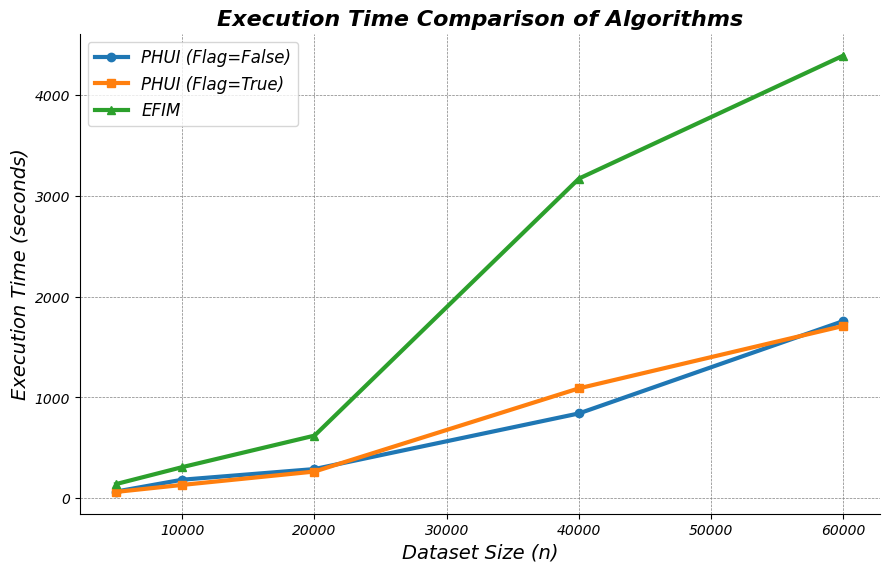

In [404]:
# Extract dataset sizes
dataset_sizes = [case["n"] for case in test_cases]
import matplotlib.pyplot as plt

# Plot results with enhanced visualization
plt.figure(figsize=(10, 6))  # Increase figure size for better clarity

# Plotting each algorithm's results with uniform line style and increased width
plt.plot(
    dataset_sizes,
    results_phui_false,
    label="PHUI (Flag=False)",
    marker="o",
    linestyle="-",
    linewidth=3,
)
plt.plot(
    dataset_sizes,
    results_phui_true,
    label="PHUI (Flag=True)",
    marker="s",
    linestyle="-",
    linewidth=3,
)
plt.plot(
    dataset_sizes, results_efim, label="EFIM", marker="^", linestyle="-", linewidth=3
)

# Adding a title with larger font
plt.title("Execution Time Comparison of Algorithms", fontsize=16, weight="bold")

# Improving x and y labels
plt.xlabel("Dataset Size (n)", fontsize=14)
plt.ylabel("Execution Time (seconds)", fontsize=14)

# Adding a legend with a better location and larger font
plt.legend(fontsize=12, loc="best")

# Adding a grid with a subtle style for better readability
plt.grid(color="gray", linestyle="--", linewidth=0.5)

# Adding a bounding box around the graph
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Automatically adjust layout to make the graph centered
plt.tight_layout()

# Adjust subplot to center the graph
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Show the graph
plt.show()